In [7]:
import numpy as np
from scipy.sparse import diags, kron, csr_matrix, csc_matrix, identity, block_diag
from scipy.sparse.linalg import spsolve, norm, inv, eigsh, eigs
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import seaborn as sns
rc('text', usetex=True) # para usar latex en matplotlib

from scipy.ndimage.filters import gaussian_filter

In [208]:
def A_B(un, a, b, domain, dim, tau, kappa):
    cache_norm_grad = {}
    def norm_grad(un, p):
        ix = domain.index(p)
        if ix not in cache_norm_grad.keys():
            dx_plus = 0
            dy_plus = 0
            dx_minus = 0
            dy_minus = 0
            val = 0
            if kappa < 0:
                if p[1]<dim[1]-1:
                    kx = domain.index((p[0], p[1]+1))
                    dx_plus = un[kx]-un[ix]
                if p[1]>0:
                    kx = domain.index((p[0], p[1]-1))
                    dx_minus = un[ix]-un[kx]
                if p[0]<dim[0]-1:
                    kx = domain.index((p[0]+1, p[1]))
                    dy_plus = un[kx]-un[ix]
                if p[0]>0:
                    kx = domain.index((p[0]-1, p[1]))
                    dy_minus = un[ix]-un[kx]
                
                val = np.sqrt( (max(dx_minus, 0)+min(dx_plus, 0))**2 + (max(dy_minus, 0)+min(dy_plus, 0))**2 )  
            cache_norm_grad[ix] = val
        return cache_norm_grad[ix]
    
    cache_harmonic_mean = {}
    def harmonic_mean(un, p, m):
        ix = domain.index(p)
        jx = domain.index(m)
        if (ix, jx) not in cache_harmonic_mean.keys():
            cache_harmonic_mean[(ix, jx)] = 2 / ( (norm_grad(un, p)/b[ix]) + (norm_grad(un, m)/b[jx]) )
        return cache_harmonic_mean[(ix, jx)]
        
    def neighbours(p, l="x"):
        px, py = p
        if l == "x":
            o = [ (px, py-1), (px, py+1) ]
            
        elif l == "y":
            o = [ (px-1, py), (px+1, py) ]
            
        return [m  for m in o if m in domain]
    
    def get_sigma(p):
        norm_grad_p = norm_grad(un, p)
        ix = domain.index(p)
        if np.isclose(norm_grad_p, 0):
            return 0
        else:
            sum_N = sum( harmonic_mean(un, p, m) for m in neighbours(p, l="x") + neighbours(p, l="y") )
            return - a[ix] * norm_grad_p * sum_N
    
    def get_delta(p, m):
        norm_grad_p = norm_grad(un, p)
        ix = domain.index(p)
        if np.isclose(norm_grad_p, 0):
            return 0
        else:
            return a[ix] * norm_grad_p * harmonic_mean(un, p, m)
    
    def get_A_row(row):
        px = row
        
        D   = [ get_sigma( (px, c) )             for c in range( dim[1]     ) ]
        D1  = [ get_delta( (px, c), (px, c+1) )  for c in range( dim[1] - 1 ) ]
        D_1 = [ get_delta( (px, c), (px, c-1) )  for c in range( 1, dim[1]  ) ]
    
        
        k = np.array([D_1, D, D1], dtype= object)
        offset = [-1, 0, 1]
        
        return diags(k, offset)
    
    def get_A_star_row(row, star):
        px = row
        
        D = [ get_delta( (px, c), (px+star, c) ) for c in range( dim[1] ) ]
        
        k = D
        offset = 0
        
        return diags(k, offset)
    
    D = [ get_A_row(row) for row in range( dim[0] ) ]                                                    
    D1 =  [csr_matrix(np.zeros((dim[1], dim[1])))] + [ get_A_star_row(row, star=1) for row in range( dim[0] - 1 ) ] + [csr_matrix(np.zeros((dim[1], dim[1])))]
    D_1 = [csr_matrix(np.zeros((dim[1], dim[1])))] + [ get_A_star_row(row, star=-1) for row in range(1, dim[0] ) ] + [csr_matrix(np.zeros((dim[1], dim[1])))]

    A0 = block_diag(D)
    A1 = csr_matrix(block_diag(D1).todense()[dim[1]:,:-dim[1]])
    A2 = csr_matrix(block_diag(D_1).todense()[:-dim[1],dim[1]:])
    
    I = csr_matrix(np.eye(un.shape[0]))
    A_star = I - tau * csr_matrix(A0+A1+A2)
#     A_star = I
    B_star = np.array( [un[domain.index(p)] + tau*kappa*norm_grad(un, p)*a[domain.index(p)] for p in domain] )

    return A_star, B_star
    

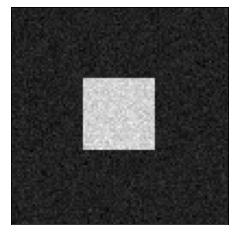

In [45]:
dim = (100, 100)
domain = [ 
    (x, y) for x in range( dim[0] ) for y in range( dim[1] )
]

img = np.random.normal(0.4, 0.005, size=dim[0] * dim[1])
for i in range(dim[0]//3):
    for j in range(dim[1]//3):
        img[(i+dim[0]//3)*dim[1]+j+dim[1]//3] += np.random.normal(0.1, 0.005)

display(plt.imshow(img.reshape(dim[0], dim[1]), cmap='gray'))
plt.xticks([]);
plt.yticks([]);
plt.savefig("img0.png", bbox_inches='tight')

In [12]:
def stopping_func(img, dim, domain, sgm=0.5, lmbd=1):
    blurred = gaussian_filter(img.reshape(dim[0], dim[1]), sigma=sgm).flatten()
    f_sgm = blurred
    
    norm_grad_f_sgm = []
    for ix in range(len(domain)):
        p = domain[ix]
        dx = 0
        dy = 0
        if p[1]<dim[1]-1:
            kx = domain.index((p[0], p[1]+1))
            dx = f_sgm[kx]-f_sgm[ix]
        if p[0]<dim[0]-1:
            kx = domain.index((p[0]+1, p[1]))
            dy = f_sgm[kx]-f_sgm[ix]

        val = np.sqrt( dx**2 + dy**2 ) 
        norm_grad_f_sgm.append(val)
    
    g = np.array( [1/(1+((g_f**2)/(lmbd**2))) for g_f in norm_grad_f_sgm] )
    
    return (g, blurred)

<ipython-input-216-91ea6e9d6236>:20: RuntimeWarning: divide by zero encountered in double_scalars
  g = np.array( [1/(1+((g_f**2)/(lmbd**2))) for g_f in norm_grad_f_sgm] )
<ipython-input-216-91ea6e9d6236>:20: RuntimeWarning: invalid value encountered in double_scalars
  g = np.array( [1/(1+((g_f**2)/(lmbd**2))) for g_f in norm_grad_f_sgm] )


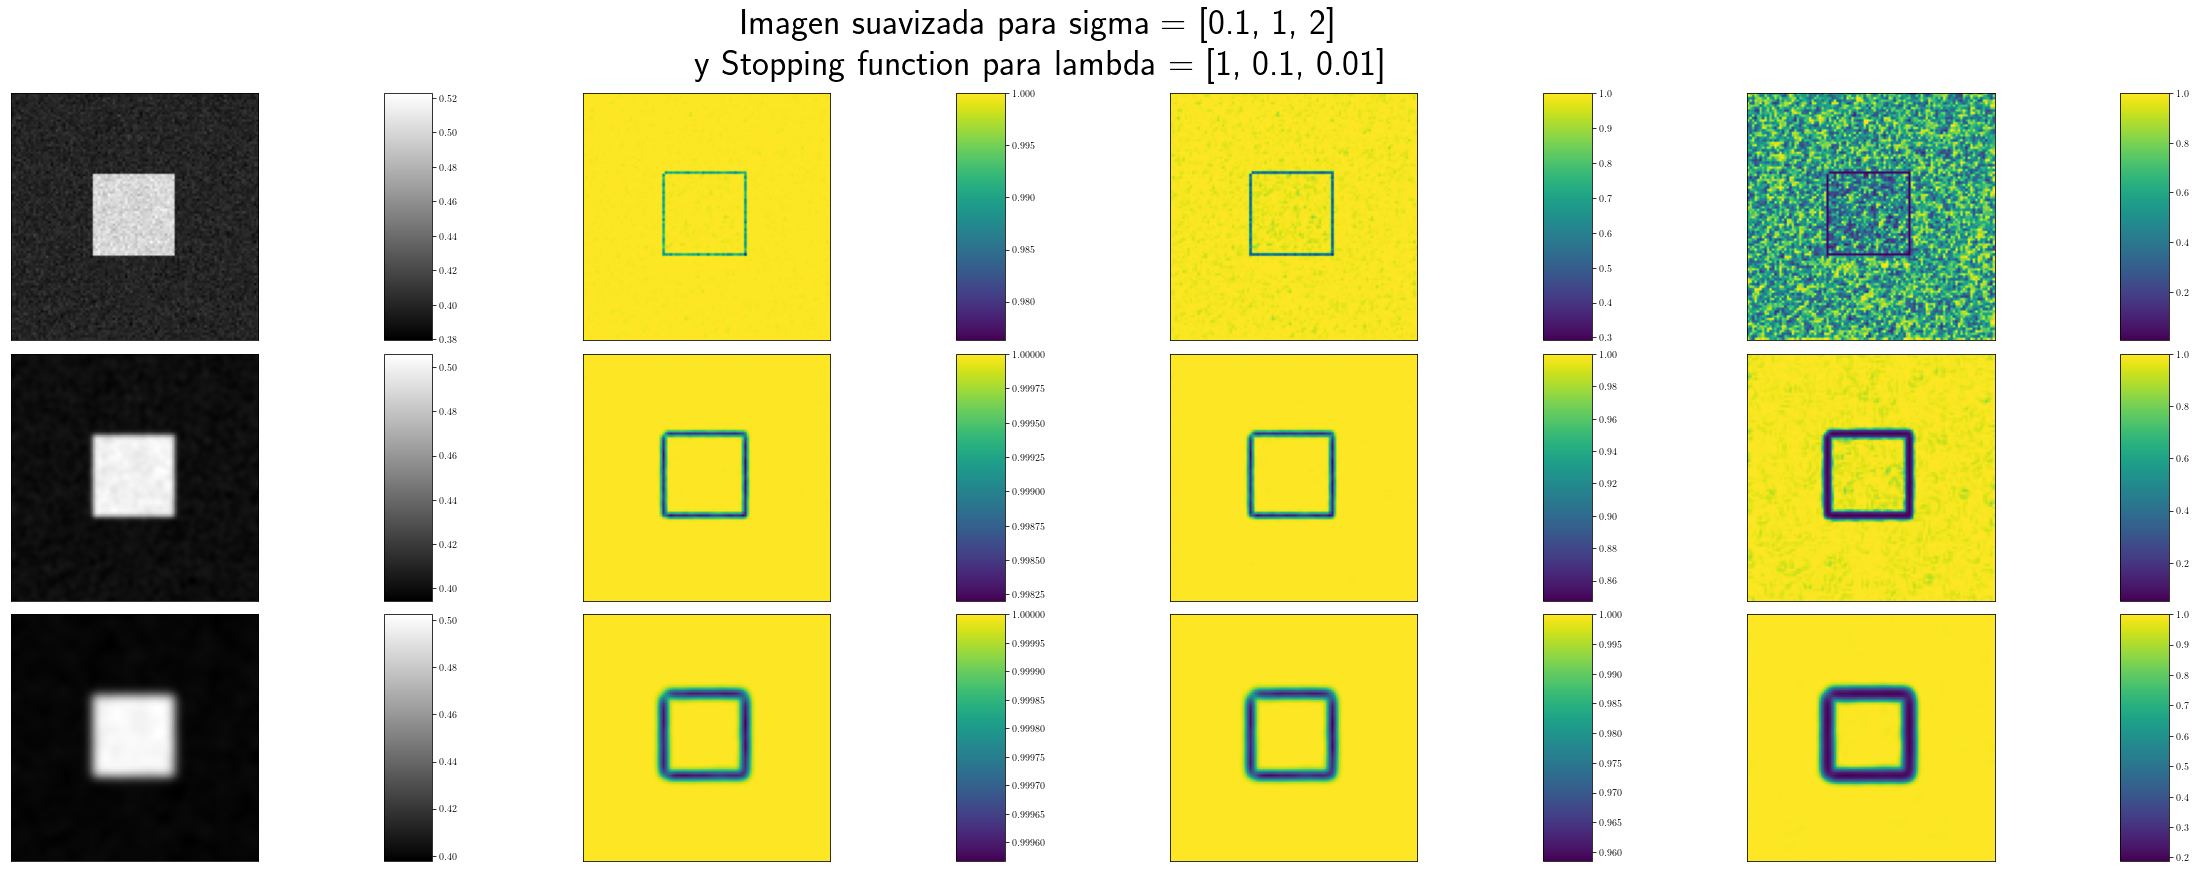

In [243]:
fig, ax = plt.subplots(3, 4*2, figsize=(4*2*4, 3*4), constrained_layout=True, 
                       gridspec_kw={"width_ratios": [1, 0.1, 1, 0.1, 1, 0.1, 1, 0.1]})
for i, sgm in enumerate([0.1, 1, 2]):
    for j, lmbd in enumerate([0, 1, 0.1, 0.01]):
        g, blurred = stopping_func(img, dim, domain, sgm=sgm, lmbd=lmbd)
        if j == 0:
            im = ax[i, j*2].imshow(blurred.reshape(dim[0], dim[1]), cmap='gray')
        else:
            im = ax[i, j*2].imshow(g.reshape(dim[0], dim[1]))
        fig.colorbar(im, cax=ax[i, j*2+1], orientation='vertical')
        ax[i, j*2].set_xticks([])
        ax[i, j*2].set_yticks([])
plt.suptitle("Imagen suavizada para sigma = [0.1, 1, 2] \ny Stopping function para lambda = [1, 0.1, 0.01]", size=18*2)
plt.savefig("stopping_function.png", bbox_inches='tight');

In [13]:
def initial_curve(x0, r, domain, dim):
    u0 = np.zeros(len(domain))
    for p in domain:
        x = (p[0]/(dim[0]-1), p[1]/(dim[1]-1))
        sgn = 0
        if (x[0]-x0[0]) ** 2 + (x[1]-x0[1]) ** 2 < r ** 2:
            sgn = 1
        else:
            sgn = -1
        dist = abs(r-linalg.norm([x[0]-x0[0], x[1]-x0[1]]))
        ix = domain.index(p)
        u0[ix] = sgn * dist
    return u0

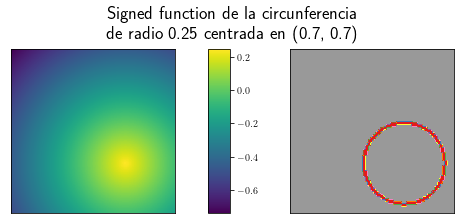

In [41]:
u0 = initial_curve((0.7, 0.7), 0.25, domain, dim)
fig, ax = plt.subplots(1, 3, figsize=(3.5*2, 3), constrained_layout=True, gridspec_kw={"width_ratios": [1, 0.1, 1]})
im = ax[0].imshow(u0.reshape(dim[0], dim[1]))
ax[0].set_xticks([])
ax[0].set_yticks([])
fig.colorbar(im, cax=ax[1], orientation='vertical')
cv0 = np.isclose(u0, 0, atol=0.01)
ax[2].imshow(cv0.reshape(dim[0], dim[1]), cmap="Set1_r")
ax[2].set_xticks([])
ax[2].set_yticks([]);
plt.suptitle("Signed function de la circunferencia \nde radio 0.25 centrada en (0.7, 0.7)", size=18)
# plt.tight_layout();
plt.savefig("u0.png", bbox_inches='tight');

In [236]:
%%time
tau = 5
kappa=-0.1
a = stopping_func(img, dim, domain, sgm=1, lmbd=0.01)[0]
b = np.ones( dim[0] * dim[1] )

u0 = initial_curve((0.5, 0.5), 0.3, domain, dim)

A0_star, B0_star = A_B(u0, a, b, domain, dim, tau, kappa)

Wall time: 1min 22s


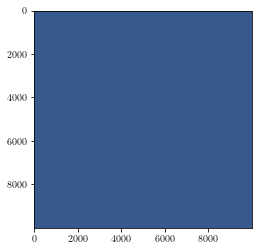

In [237]:
display(plt.imshow(A0_star.todense()))

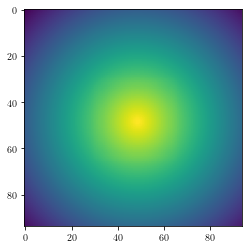

In [238]:
display(plt.imshow(B0_star.reshape(dim[0], dim[1])[1:-5, 1:-5]))

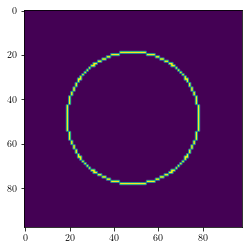

In [241]:
un = u0
cvn = np.isclose(un, 0, atol=0.005)
plt.imshow(cvn.reshape(dim[0], dim[1])[1:-1, 1:-1])

In [ ]:
%%time
for n in range(50):
    print("n:", n)
    An_star, Bn_star = A_B(un, a, b, domain, dim, tau, kappa)
    un1 = spsolve(An_star, Bn_star)
    cvn = np.isclose(un1, 0, atol=0.005)

    fig, ax = plt.subplots(1, 3, figsize=(3.5*2, 3), constrained_layout=True, gridspec_kw={"width_ratios": [1, 0.1, 1]})
    im = ax[0].imshow(un1.reshape(dim[0], dim[1]))
    ax[0].set_xticks([]);
    ax[0].set_yticks([]);
    fig.colorbar(im, cax=ax[1], orientation='vertical')

    ax[2].imshow(cvn.reshape(dim[0], dim[1]), cmap="Set1_r")
    ax[2].set_xticks([]);
    ax[2].set_yticks([]);
    # plt.suptitle("Signed function de la circunferencia \nde radio 0.25 centrada en (0.7, 0.7)", size=18)
    # plt.tight_layout();
    plt.savefig(f"image_test3/un_{n}.png", bbox_inches='tight');

    un = un1

n: 0
n: 1
n: 2
n: 3
n: 4
n: 5
n: 6
n: 7
